# Импорт библиотек

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/MTS ML Cup

/content/drive/MyDrive/MTS ML Cup


In [3]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/MTS ML Cup/src')

import os
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore');

In [ ]:
!pip install catboost

In [ ]:
!pip install lightgbm

In [ ]:
!pip install xgboost

In [8]:
import pandas as pd
import numpy as np
import bisect

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import sklearn.metrics as m
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

In [9]:
from metric_functions import get_metrics_classification, get_metrics_multiclass, 
check_overfitting_classification, check_overfitting_multiclass

In [10]:
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')

In [11]:
RAND = 42

final_types = {
    'user_id': 'int32',
    'part_of_day_day': 'int16',
    'part_of_day_night': 'int16',
    'day_pct': 'float32',
    'evening_pct': 'float32',
    'morning_pct': 'float32',
    'night_pct': 'float32',
    'act_days': 'int16',
    'avg_req_per_day': 'float32',
    'requests_std': 'float32',
    'act_days_pct': 'float32',
    'cpe_type_cd': 'category',
    'cpe_model_os_type': 'category',
    'cpe_manufacturer_name': 'category',
    'price': 'float32',
    'region_cnt': 'int8',
    'city_cnt': 'int8',
    'url_host_cnt': 'int16',
}

# Сбор всех данных

In [12]:
id_to_submit = pd.read_parquet('submit.pqt')

In [13]:
targets = pd.read_parquet('public_train.pqt')

In [14]:
df = pd.read_csv('data_agg/df_final.csv')

In [16]:
df.head()

,user_id,part_of_day_day,part_of_day_night,day_pct,evening_pct,morning_pct,night_pct,act_days,avg_req_per_day,requests_std,act_days_pct,cpe_type_cd,cpe_model_os_type,cpe_manufacturer_name,price,region_cnt,city_cnt,url_host_cnt
0,4,199,10,0.336717,0.287648,0.358714,0.016920,20,38.850000,0.647632,0.4650,smartphone,Android,Huawei,12990.0,5,9,108
1,16,443,137,0.359870,0.260764,0.268075,0.111292,64,39.515625,1.397836,0.8647,smartphone,Android,Samsung,9583.0,1,1,50
2,18,566,34,0.503111,0.101333,0.365333,0.030222,32,60.937500,1.204972,0.8423,smartphone,Android,Samsung,22887.0,1,2,141
3,26,180,126,0.176817,0.400786,0.298625,0.123772,20,71.800000,0.688696,0.9090,smartphone,Android,Samsung,4990.0,1,1,126
4,27,808,342,0.302622,0.331461,0.237828,0.128090,67,66.074620,1.088583,0.9307,smartphone,Android,Xiaomi,12990.0,1,2,209


In [17]:
df = df.astype(final_types)
df.dtypes

user_id                     int32
part_of_day_day             int16
part_of_day_night           int16
day_pct                   float32
evening_pct               float32
morning_pct               float32
night_pct                 float32
act_days                    int16
avg_req_per_day           float32
requests_std              float32
act_days_pct              float32
cpe_type_cd              category
cpe_model_os_type        category
cpe_manufacturer_name    category
price                     float32
region_cnt                   int8
city_cnt                     int8
url_host_cnt                int16
dtype: object

In [18]:
df.shape

(415317, 18)

In [20]:
url_emb = pd.read_csv('embeddings/url_emb.csv')
url_emb = url_emb.add_suffix('_url').rename(columns={'user_id_url': 'user_id'})

In [21]:
reg_emb = pd.read_csv('embeddings/reg_emb.csv')
reg_emb = reg_emb.add_suffix('_reg').rename(columns={'user_id_reg': 'user_id'})

In [22]:
city_emb = pd.read_csv('embeddings/city_emb.csv')
city_emb = city_emb.add_suffix('_city').rename(columns={'user_id_city': 'user_id'})

In [23]:
model_emb = pd.read_csv('embeddings/model_emb.csv')
model_emb = model_emb.add_suffix('_model').rename(
    columns={'user_id_model': 'user_id'})

In [24]:
metrics_gender_baseline = pd.read_csv('metrics/metrics_gender_baseline.csv')
metrics_age_baseline = pd.read_csv('metrics/metrics_age_baseline.csv')

# Baseline gender prediction

In [51]:
df_train = targets.merge(df, how='inner', on=['user_id']) \
                  .merge(url_emb, how='inner', on='user_id') \
                  .merge(city_emb, how='inner', on=['user_id']) \
                  .merge(reg_emb, how='inner', on=['user_id']) \
                  .merge(model_emb, how='inner', on=['user_id'])

df_train = df_train[df_train['is_male'] != 'NA']
df_train = df_train.dropna()
df_train['is_male'] = df_train['is_male'].map(int)
df_train['is_male'].value_counts()

1    135331
0    128994
Name: is_male, dtype: int64

In [52]:
%%time
X = df_train.drop(['user_id', 'age', 'is_male'], axis=1)
y = df_train['is_male']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

# значение для scale_pos_weight
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

CPU times: user 1.09 s, sys: 300 ms, total: 1.39 s
Wall time: 1.38 s


## LGBM

In [38]:
%%time
lgbm_gender = LGBMClassifier(random_state=RAND, scale_pos_weight=ratio)
eval_set = [(X_val, y_val)]

lgbm_gender.fit(X_train,
                y_train,
                eval_metric='auc',
                eval_set=eval_set,
                early_stopping_rounds=100,
                verbose=False)

CPU times: user 1min 38s, sys: 1.05 s, total: 1min 39s
Wall time: 28.6 s


LGBMClassifier(random_state=42, scale_pos_weight=0.9531740695036613)

In [39]:
print(
    f'GINI по полу {2 * m.roc_auc_score(y_test, lgbm_gender.predict_proba(X_test)[:,1]) - 1:2.3f}'
)

GINI по полу 0.625


In [40]:
check_overfitting_classification(lgbm_gender, X_train, y_train, X_test, y_test)

ROC-AUC train = 0.834
ROC-AUC test = 0.813
delta = 2.6%


In [41]:
y_pred_test = lgbm_gender.predict(X_test)
y_score_test = lgbm_gender.predict_proba(X_test)

metrics_gender = metrics_gender_baseline.append(
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_score_test,
                               name='LGBMBaseline_embeddings'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
1,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
2,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683
3,RandomForestBaseline,0.584381,0.585569,0.584974,0.600485,0.200970
0,LGBMBaseline_embeddings,0.742578,0.720794,0.731523,0.812632,0.625265


## CatBoost

In [55]:
%%time
cat_features = X.select_dtypes('category').columns.tolist()
cat_gender = CatBoostClassifier(allow_writing_files=False,
                                random_state=RAND,
                                eval_metric="AUC",
                                cat_features=cat_features,
                                scale_pos_weight=ratio)
eval_set = [(X_val, y_val)]

cat_gender.fit(X_train_,
               y_train_,
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

CPU times: user 13min 59s, sys: 14.5 s, total: 14min 13s
Wall time: 4min 12s


In [56]:
print(
    f'GINI по полу {2 * m.roc_auc_score(y_test, cat_gender.predict_proba(X_test)[:,1]) - 1:2.3f}'
)

GINI по полу 0.688


In [57]:
check_overfitting_classification(cat_gender, X_train, y_train, X_test, y_test)

ROC-AUC train = 0.893
ROC-AUC test = 0.844
delta = 5.79%


In [58]:
y_pred_test = cat_gender.predict(X_test)
y_score_test = cat_gender.predict_proba(X_test)
metrics_gender = metrics_gender[:5]
metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_score_test,
                               name='CatBoostBaseline_embeddings'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
1,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
2,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683
3,RandomForestBaseline,0.584381,0.585569,0.584974,0.600485,0.200970
0,LGBMBaseline_embeddings,0.742578,0.720794,0.731523,0.812632,0.625265
0,CatBoostBaseline_embeddings,0.770574,0.748282,0.759264,0.843999,0.687998


## XGBoost

In [59]:
%%time
X = pd.get_dummies(df_train.drop(['user_id', 'age', 'is_male'], axis=1))
y = df_train['is_male']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

# значение для scale_pos_weight
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

CPU times: user 1.5 s, sys: 660 ms, total: 2.16 s
Wall time: 2.15 s


In [60]:
%%time
xgb_gender = XGBClassifier(random_state=RAND, scale_pos_weight=ratio)
eval_set = [(X_val, y_val)]

xgb_gender.fit(X_train,
               y_train,
               eval_metric='auc',
               eval_set=eval_set,
               early_stopping_rounds=100,
               verbose=0)

CPU times: user 43min 11s, sys: 3.2 s, total: 43min 14s
Wall time: 11min 54s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [61]:
print(
    f'GINI по полу {2 * m.roc_auc_score(y_test, xgb_gender.predict_proba(X_test)[:,1]) - 1:2.3f}'
)

GINI по полу 0.641


In [62]:
check_overfitting_classification(xgb_gender, X_train, y_train, X_test, y_test)

ROC-AUC train = 0.895
ROC-AUC test = 0.821
delta = 9.09%


In [63]:
y_pred_test = xgb_gender.predict(X_test)
y_score_test = xgb_gender.predict_proba(X_test)

metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_score_test,
                               name='XGBoostBaseline_embeddings'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
1,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
2,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683
3,RandomForestBaseline,0.584381,0.585569,0.584974,0.600485,0.200970
0,LGBMBaseline_embeddings,0.742578,0.720794,0.731523,0.812632,0.625265
0,CatBoostBaseline_embeddings,0.770574,0.748282,0.759264,0.843999,0.687998
0,XGBoostBaseline_embeddings,0.745593,0.728294,0.736842,0.820728,0.641457


Вывод: самые высокие метрики у catboost с эмбеддингами

In [66]:
metrics_gender.to_csv('metrics/metrics_gender_embeddings.csv', index=False)

# Baseline age prediction

In [25]:
def age_bucket(x):
    return bisect.bisect_left([18, 25, 35, 45, 55, 65], x)

## LGBM

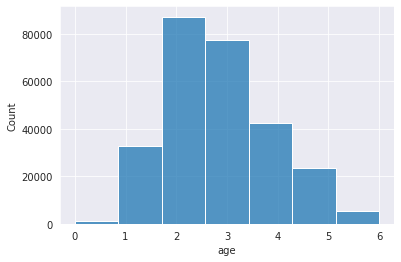

In [26]:
df_trn = targets.merge(df, how='inner', on=['user_id']) \
    .merge(url_emb, how='inner', on='user_id') \
    .merge(model_emb, how='inner', on=['user_id']) \
    .merge(reg_emb, how='inner', on=['user_id']) \
    .merge(city_emb, how='inner', on=['user_id'])

df_trn = df_trn[df_trn['age'] != 'NA']
df_trn = df_trn.dropna()
df_trn['age'] = df_trn['age'].map(age_bucket)
sns.histplot(df_trn['age'], bins=7)

In [27]:
# разбивка данных на train и test
X = df_trn.drop(['age', 'is_male', 'user_id'], axis=1)
y = df_trn['age']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

n_classes = len(set(y))
y_train_bin = label_binarize(y_train, classes=list(set(y)))
y_test_bin = label_binarize(y_test, classes=list(set(y)))

In [28]:
%%time
lgbm_age = LGBMClassifier(random_state=RAND,
                          class_weight='balanced',
                          objective='multiclass')
eval_set = [(X_val, y_val)]

lgbm_age.fit(X_train_,
             y_train_,
             eval_set=eval_set,
             early_stopping_rounds=100,
             verbose=False)

CPU times: user 9min 1s, sys: 1.43 s, total: 9min 2s
Wall time: 2min 30s


LGBMClassifier(class_weight='balanced', objective='multiclass', random_state=42)

In [29]:
check_overfitting_multiclass(lgbm_age, X_train, y_train_bin, X_test, y_test_bin)

ROC-AUC train = 0.840
ROC-AUC test = 0.765
delta = 9.79%


In [30]:
print(
    m.classification_report(y_test,
                            lgbm_age.predict(X_test),
                            target_names=[
                                '<18', '18-25', '25-34', '35-44', '45-54',
                                '55-65', '65+'
                            ]))

              precision    recall  f1-score   support

         <18       0.03      0.11      0.05       207
       18-25       0.36      0.63      0.46      6528
       25-34       0.51      0.34      0.41     17454
       35-44       0.43      0.27      0.33     15497
       45-54       0.29      0.25      0.27      8489
       55-65       0.22      0.35      0.27      4716
         65+       0.09      0.42      0.15      1101

    accuracy                           0.34     53992
   macro avg       0.27      0.34      0.28     53992
weighted avg       0.40      0.34      0.35     53992



In [31]:
y_pred = lgbm_age.predict(X_test)
y_score = lgbm_age.predict_proba(X_test)

metrics_age = metrics_age_baseline.append(
    get_metrics_multiclass(y_test_bin=y_test_bin,
                           y_test=y_test,
                           y_pred=y_pred,
                           y_prob=y_score,
                           name='LGBM_Baseline_embeddings',
                           type_multi='ovo'))
metrics_age

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,LGBM_Baseline,0.665440,0.223941,0.206321,0.223941,0.257902,0.223941,0.186803,1.756957
1,CatBoost_Baseline,0.678626,0.363721,0.260785,0.363721,0.191032,0.363721,0.182633,1.483299
2,RandomForest_Baseline,0.630193,0.345829,0.219442,0.345829,0.180165,0.345829,0.170520,1.794659
0,LGBM_Baseline_embeddings,0.764762,0.344662,0.274598,0.344662,0.339979,0.344662,0.275853,1.508385


## Catboost

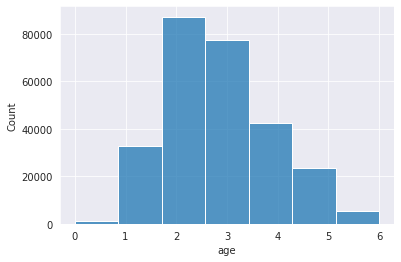

In [32]:
df_trn_cat = targets.merge(df, how='inner', on=['user_id']) \
                    .merge(url_emb, how='inner', on='user_id') \
                    .merge(model_emb, how='inner', on=['user_id']) \
                    .merge(reg_emb, how='inner', on=['user_id']) \
                    .merge(city_emb, how='inner', on=['user_id'])

df_trn_cat = df_trn_cat[df_trn_cat['age'] != 'NA']
df_trn_cat = df_trn_cat.dropna()
df_trn_cat['age'] = df_trn_cat['age'].map(age_bucket)
sns.histplot(df_trn_cat['age'], bins=7)

In [33]:
# разбивка данных на train и test
X = df_trn_cat.drop(['age', 'is_male', 'user_id'], axis=1)
y = df_trn_cat['age']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

n_classes = len(set(y))
y_train_bin = label_binarize(y_train, classes=list(set(y)))
y_test_bin = label_binarize(y_test, classes=list(set(y)))

In [34]:
%%time
cat_features = X.select_dtypes('category').columns.tolist()
cat_age = CatBoostClassifier(allow_writing_files=False,
                             cat_features=cat_features,
                             random_state=RAND)
eval_set = [(X_val, y_val)]

cat_age.fit(X_train,
            y_train,
            eval_set=eval_set,
            early_stopping_rounds=100,
            verbose=False)

CPU times: user 2h 2min, sys: 7min 32s, total: 2h 9min 33s
Wall time: 36min 13s


In [35]:
check_overfitting_multiclass(cat_age, X_train, y_train_bin, X_test, y_test_bin)

ROC-AUC train = 0.867
ROC-AUC test = 0.789
delta = 9.86%


In [36]:
print(
    m.classification_report(y_test,
                            cat_age.predict(X_test),
                            target_names=[
                                '<18', '18-25', '25-34', '35-44', '45-54',
                                '55-65', '65+'
                            ]))

              precision    recall  f1-score   support

         <18       0.00      0.00      0.00       207
       18-25       0.53      0.32      0.40      6528
       25-34       0.49      0.63      0.55     17454
       35-44       0.40      0.52      0.46     15497
       45-54       0.38      0.22      0.28      8489
       55-65       0.41      0.20      0.27      4716
         65+       0.26      0.02      0.03      1101

    accuracy                           0.44     53992
   macro avg       0.35      0.27      0.28     53992
weighted avg       0.44      0.44      0.42     53992



In [37]:
y_pred = cat_age.predict(X_test)
y_score = cat_age.predict_proba(X_test)

metrics_age = metrics_age.append(
    get_metrics_multiclass(y_test_bin=y_test_bin,
                           y_test=y_test,
                           y_pred=y_pred,
                           y_prob=y_score,
                           name='CatBoost_Baseline_embeddings',
                           type_multi='ovo'))
metrics_age

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,LGBM_Baseline,0.665440,0.223941,0.206321,0.223941,0.257902,0.223941,0.186803,1.756957
1,CatBoost_Baseline,0.678626,0.363721,0.260785,0.363721,0.191032,0.363721,0.182633,1.483299
2,RandomForest_Baseline,0.630193,0.345829,0.219442,0.345829,0.180165,0.345829,0.170520,1.794659
0,LGBM_Baseline_embeddings,0.764762,0.344662,0.274598,0.344662,0.339979,0.344662,0.275853,1.508385
0,CatBoost_Baseline_embeddings,0.789473,0.444547,0.351707,0.444547,0.272629,0.444547,0.282677,1.300392


Вывод: самые высокие метрики у catboost с эмбеддингами

In [38]:
metrics_age.to_csv('metrics/metrics_age_embeddings.csv', index=False)

# Submission

In [ ]:
cat_gender.fit(df_train.drop(['user_id', 'age', 'is_male'], axis=1),
               df_train['is_male'],
               verbose=False)

In [ ]:
id_to_sub_data = id_to_submit.merge(df, how='inner', on=['user_id']) \
    .merge(url_emb, how='inner', on='user_id') \
    .merge(city_emb, how='inner', on=['user_id']) \
    .merge(reg_emb, how='inner', on=['user_id']) \
    .merge(model_emb, how='inner', on=['user_id']) \
    .drop('user_id', axis=1)

id_to_submit['is_male'] = cat_gender.predict_proba(id_to_sub_data)[:, 1]

In [ ]:
cat_age.fit(df_trn.drop(['age', 'is_male', 'user_id'], axis=1),
            df_trn['age'],
            verbose=False)

In [ ]:
id_to_submit['age'] = cat_age.predict(id_to_sub_data)

In [ ]:
import datetime

cur_time = str(datetime.datetime.now()).replace(' ', '_')[:16]
sub_name = 'submissions/submission_' + cur_time + '.csv'
id_to_submit.to_csv(sub_name, index=False)